In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src.config import Config
from src.episode import Episode
from src.episode_dataset import EpisodeDataset
from src.policy import Policy
from src.reward_model import RewardModel
from src.grpo_trainer import GRPOTrainer
from src.utils import get_color, normalize_min_max, top_k_sampling
from src.episode_batch_reat_sampler import EpisodeBatchRepeatSampler

# Setup
---

In [2]:
config = Config()

training_dataset = EpisodeDataset(config=config, split="TRAIN")
print(f"training_dataset : {len(training_dataset)}")

test_dataset = EpisodeDataset(config=config, split="TEST")
print(f"test_dataset : {len(test_dataset)}")

train_batch_repeat_sampler = EpisodeBatchRepeatSampler(
    dataset=training_dataset,
    batch_size=config.train_batch_size,
    repeats=config.episode_steps,
)
print(f"train_batch_repeat_sampler: {list(train_batch_repeat_sampler)}")

train_dataloader = DataLoader(
    training_dataset,
    batch_size=config.train_batch_size,
    sampler=train_batch_repeat_sampler,
)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

training_dataset : 10000
test_dataset : 2000
train_batch_repeat_sampler: [2219, 9890, 6427, 5541, 2530, 4079, 536, 3371, 3255, 7236, 5780, 2963, 1695, 5083, 8877, 5702, 9327, 8382, 2991, 8300, 8898, 7700, 3039, 38, 1488, 8655, 1225, 547, 9520, 8906, 4527, 3656, 3575, 2396, 67, 1363, 8322, 2357, 306, 5880, 83, 5150, 8049, 8097, 580, 4409, 9953, 4309, 9614, 6274, 2219, 9890, 6427, 5541, 2530, 4079, 536, 3371, 3255, 7236, 5780, 2963, 1695, 5083, 8877, 5702, 9327, 8382, 2991, 8300, 8898, 7700, 3039, 38, 1488, 8655, 1225, 547, 9520, 8906, 4527, 3656, 3575, 2396, 67, 1363, 8322, 2357, 306, 5880, 83, 5150, 8049, 8097, 580, 4409, 9953, 4309, 9614, 6274, 2219, 9890, 6427, 5541, 2530, 4079, 536, 3371, 3255, 7236, 5780, 2963, 1695, 5083, 8877, 5702, 9327, 8382, 2991, 8300, 8898, 7700, 3039, 38, 1488, 8655, 1225, 547, 9520, 8906, 4527, 3656, 3575, 2396, 67, 1363, 8322, 2357, 306, 5880, 83, 5150, 8049, 8097, 580, 4409, 9953, 4309, 9614, 6274, 2219, 9890, 6427, 5541, 2530, 4079, 536, 3371, 3255, 723

fov: torch.Size([11, 11])


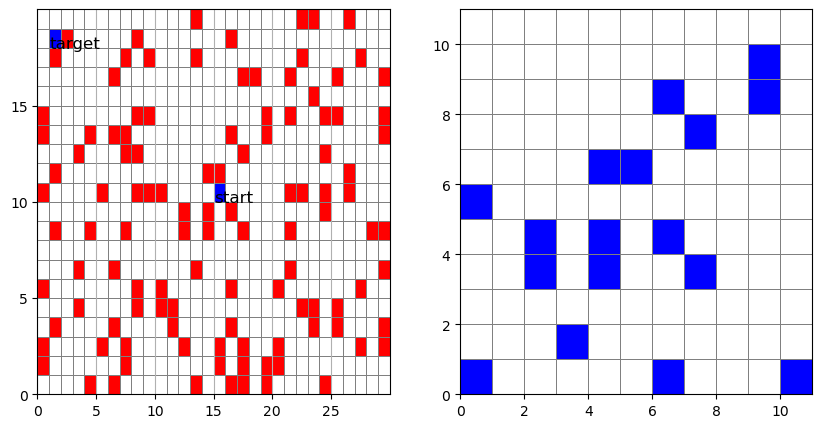

In [3]:
episode1 = training_dataset.episodes[0]

# Viz world
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
episode1.viz(ax=axes[0])

# Viz fov
fov = episode1.world.fov(center_pos=episode1.agent.start_state.position())
print(f"fov: {fov.size()}")
# print(f"fov: {fov}")
episode1.world.viz_fov(center_pos=episode1.agent.start_state.position(), ax=axes[1])
plt.show()

In [4]:
def train_and_plot_policy(policy: Policy, debug: bool = False):
    episode = Episode.new(id="train")
    print(f"start: {episode.agent.current_state}")
    episode.train(steps=20, policy=policy, debug=debug)
    print(f"start2: {episode.agent.current_state}")

    fig = plt.figure(figsize=config.figure_size)
    ax = fig.add_subplot(1, 1, 1)
    episode.viz(ax=ax, color=get_color(0))
    plt.show()

    return episode


def inference_and_plot_policy(policy: Policy, steps: int = 20, debug: bool = False):
    episode = Episode.new(id="inference")
    # print(f"start state: {episode.agent.start_state}")
    # print(f"target state: {episode.agent.target_state}")
    episode.inference_steps_by_policy(steps=steps, policy=policy, debug=debug)
    # print(f"end state: {episode.agent.current_state}")

    fig = plt.figure(figsize=config.figure_size)
    ax = fig.add_subplot(1, 1, 1)
    episode.viz(ax=ax, color=get_color(0))
    plt.show()

    return episode

step: 0, logits: tensor([[ 0.1700,  0.6123, -0.5724,  0.1543,  0.3191, -0.1179, -0.4621,  0.3502,
          1.1113]]), logit_prob: tensor([[0.1857]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[8]]), state: tensor([0.5333, 0.5500])
step: 1, logits: tensor([[ 0.6436,  0.3476, -0.6630,  0.4686,  0.1118, -0.1028, -0.9284,  0.0957,
          1.3780]]), logit_prob: tensor([[0.1819]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[8]]), state: tensor([0.5667, 0.6000])
step: 2, logits: tensor([[-0.6120,  0.7457, -0.8218, -0.0072,  0.1814, -0.5314, -0.9195,  0.5477,
          1.3766]]), logit_prob: tensor([[0.1921]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[8]]), state: tensor([0.6000, 0.6500])
step: 3, logits: tensor([[ 0.4182, -0.1343, -1.1355,  0.3207,  0.1969, -0.2275, -0.8156,  0.9832,
          1.2178]]), logit_prob: tensor([[0.1712]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[8]]), state: tensor([0.6333, 0.7000])
step: 4, logits: tensor([[ 0.0083,  0.3159, -0.3

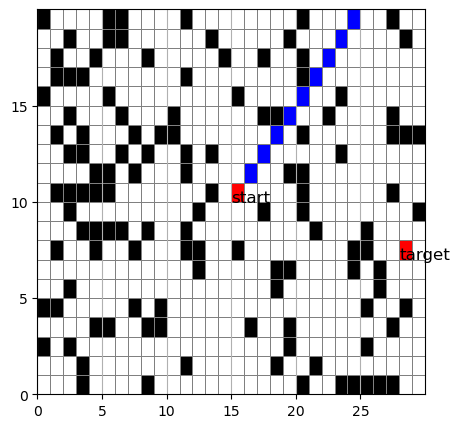

In [5]:
policy = Policy(config=config)
episode = inference_and_plot_policy(policy=policy, debug=True)
# episode.agent.action_history

# Training Loop
---

In [6]:
policy = Policy(config=config)
reward_model = RewardModel(config=config)
trainer = GRPOTrainer(config=config, policy=policy, reward_model=reward_model)

In [7]:
trainer.train(dataset=training_dataset, debug=False)

train_batch_repeat_sampler: [1882, 1796, 1397, 5629, 4525, 5444, 2980, 172, 4195, 418, 8812, 4173, 1885, 6296, 3301, 6362, 6139, 1799, 7714, 6203, 4595, 6205, 4691, 3410, 9148, 6122, 3648, 2614, 9210, 2703, 921, 8628, 4633, 7258, 4961, 2079, 9682, 8818, 4535, 6835, 7870, 6634, 3541, 8596, 1306, 4912, 5691, 1363, 5486, 1730, 1882, 1796, 1397, 5629, 4525, 5444, 2980, 172, 4195, 418, 8812, 4173, 1885, 6296, 3301, 6362, 6139, 1799, 7714, 6203, 4595, 6205, 4691, 3410, 9148, 6122, 3648, 2614, 9210, 2703, 921, 8628, 4633, 7258, 4961, 2079, 9682, 8818, 4535, 6835, 7870, 6634, 3541, 8596, 1306, 4912, 5691, 1363, 5486, 1730, 1882, 1796, 1397, 5629, 4525, 5444, 2980, 172, 4195, 418, 8812, 4173, 1885, 6296, 3301, 6362, 6139, 1799, 7714, 6203, 4595, 6205, 4691, 3410, 9148, 6122, 3648, 2614, 9210, 2703, 921, 8628, 4633, 7258, 4961, 2079, 9682, 8818, 4535, 6835, 7870, 6634, 3541, 8596, 1306, 4912, 5691, 1363, 5486, 1730, 1882, 1796, 1397, 5629, 4525, 5444, 2980, 172, 4195, 418, 8812, 4173, 1885, 6296

/Users/chengbai/ml/cheng_git/rf_agent/src/reward_model.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dxy = torch.tensor(action.get_udpate())


step: 0, logits: tensor([[   12773.4570, -1218520.2500,    10664.8740,    15787.1035,
            19185.0918,    16879.3203,    10706.0029,    13504.6953,
            14152.4316]]), logit_prob: tensor([[0.1200]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[4]]), state: tensor([0.5000, 0.5000])
step: 1, logits: tensor([[   12773.4570, -1218520.2500,    10664.8740,    15787.1035,
            19185.0918,    16879.3203,    10706.0029,    13504.6953,
            14152.4316]]), logit_prob: tensor([[0.1200]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[4]]), state: tensor([0.5000, 0.5000])
step: 2, logits: tensor([[   12773.4570, -1218520.2500,    10664.8740,    15787.1035,
            19185.0918,    16879.3203,    10706.0029,    13504.6953,
            14152.4316]]), logit_prob: tensor([[0.1200]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[4]]), state: tensor([0.5000, 0.5000])
step: 3, logits: tensor([[   12773.4570, -1218520.2500,    10664.8740,    15787.1035,
           

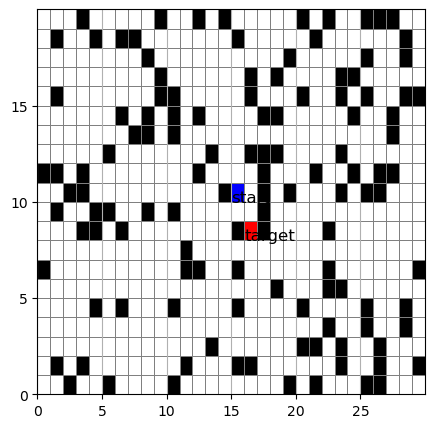

episode reward: -100.0


In [8]:
episode = inference_and_plot_policy(policy=policy, debug=True)
print(f"episode reward: {episode.reward(reward_model=reward_model)}")